In [1]:
!pip install torch torchvision torchaudio --user

In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [2]:
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

In [3]:
train_data = datasets.ImageFolder(root='dataset', transform=transform)
train_size = int(0.8*len(train_data))
test_size = len(train_data)-train_size
train_dataset, test_dataset = random_split(train_data,[train_size, test_size])

train_loader = DataLoader(train_dataset , batch_size=16 ,shuffle=True)
test_loader  = DataLoader(test_dataset,batch_size=16 ,shuffle=False)

In [4]:
num_classes = len(train_data.classes)
print(f"classes: {train_data.classes}")

classes: ['not_stop', 'stop']


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
class StopSignCNN(nn.Module):
    def __init__(self):
        super(StopSignCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32*16*16,128)
        self.fc2 = nn.Linear(128,2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32*16*16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
        

In [7]:
model = StopSignCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images,labels in train_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}), loss:{running_loss/len(train_loader)}")

train_model(model, train_loader, criterion, optimizer, epochs=10)

Epoch 1/10), loss:0.6486442685127258
Epoch 2/10), loss:0.5335666239261627
Epoch 3/10), loss:0.43842341005802155
Epoch 4/10), loss:0.38824629634618757
Epoch 5/10), loss:0.282805997133255
Epoch 6/10), loss:0.19766577556729317
Epoch 7/10), loss:0.2919948846101761
Epoch 8/10), loss:0.23879201114177703
Epoch 9/10), loss:0.12966041639447212
Epoch 10/10), loss:0.08107748068869114


In [16]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs,1)
            total +=labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {10*correct/total:.2f}%")
evaluate_model(model, test_loader)

Accuracy: 7.50%


In [17]:
torch.save(model.state_dict(),'stopsign_cnn.pth')
print("Model saved successfully!")

Model saved successfully!


In [18]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt

Image:stop_1.jpeg, predicted:Stop


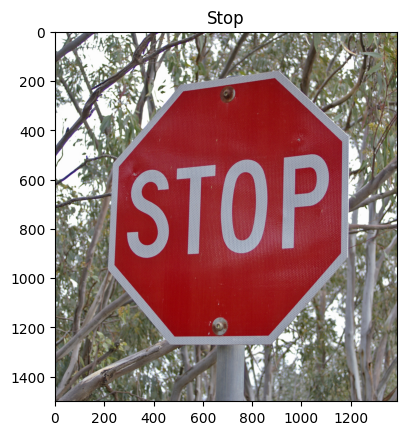

Image:stop_2.jpeg, predicted:Stop


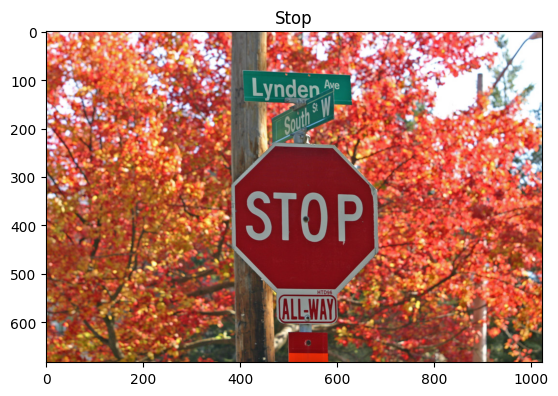

Image:stop_3.jpeg, predicted:Stop


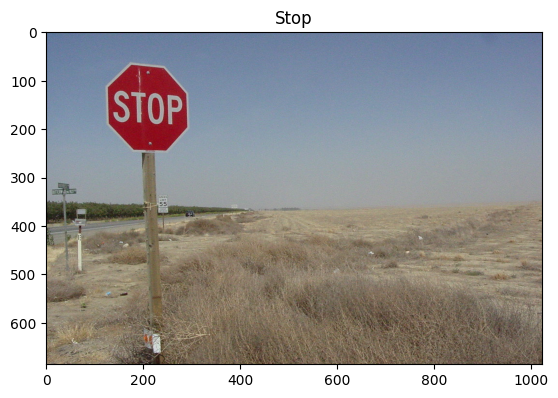

Image:stop_4.jpeg, predicted:Stop


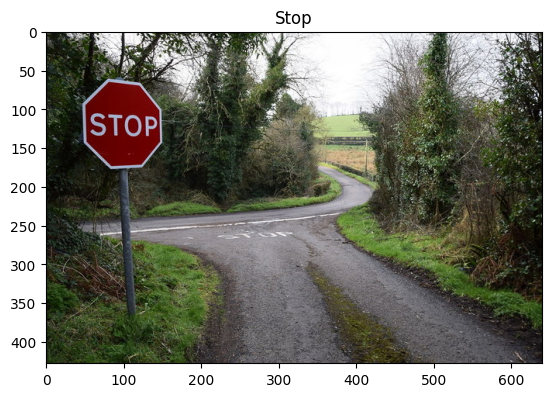

Image:not_stop_1.jpeg, predicted:Stop


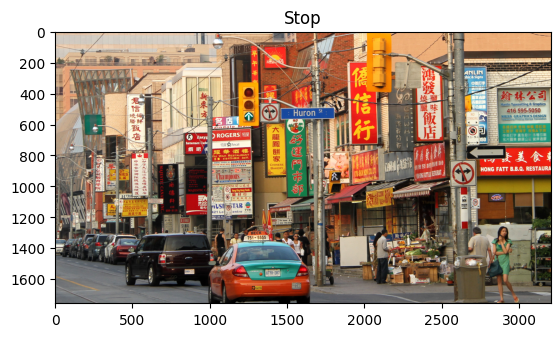

Image:not_stop_2.jpeg, predicted:not_Stop


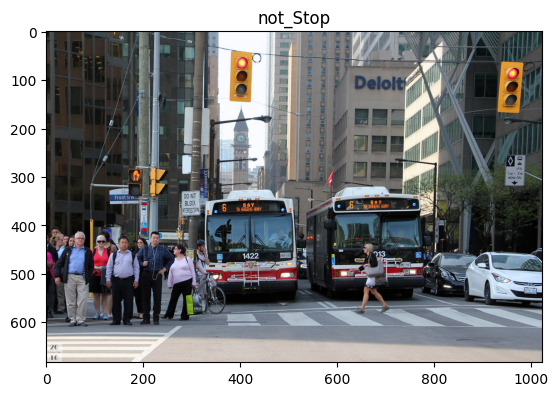

Image:not_stop_3.jpeg, predicted:Stop


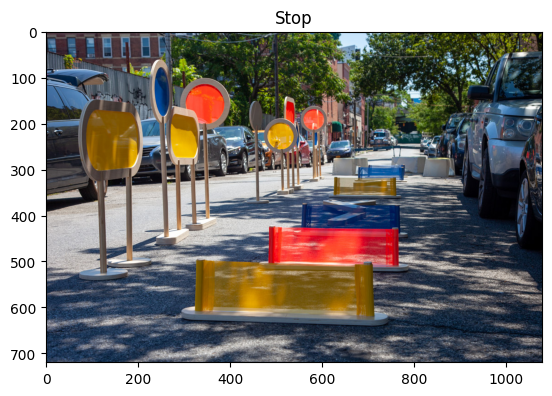

Image:not_stop_4.jpeg, predicted:not_Stop


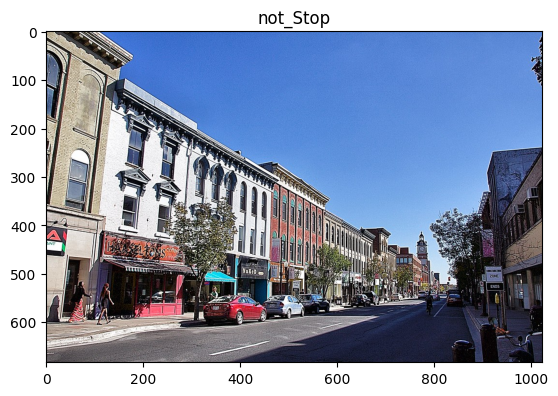

Image:online_stop.jpeg, predicted:Stop


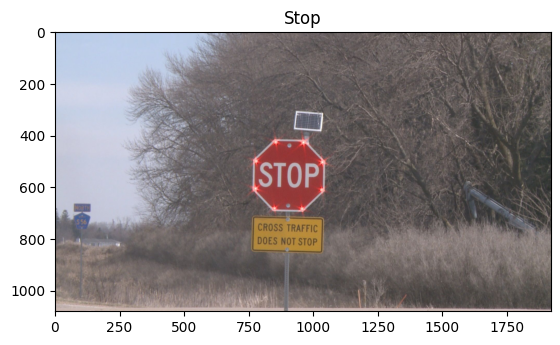

Image:online_not_stop.jpg, predicted:not_Stop


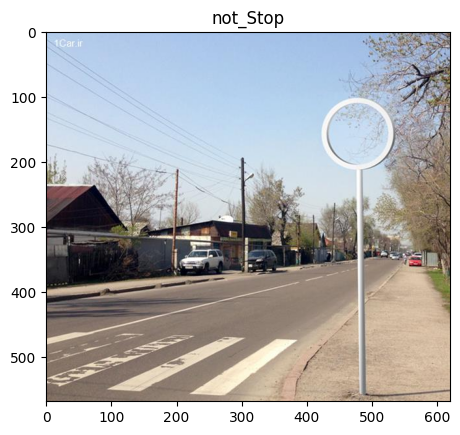

In [26]:
imageNames = ['stop_1.jpeg','stop_2.jpeg','stop_3.jpeg','stop_4.jpeg',
              'not_stop_1.jpeg','not_stop_2.jpeg','not_stop_3.jpeg','not_stop_4.jpeg', 'online_stop.jpeg', 'online_not_stop.jpg' ]
for imageName in imageNames:
    model.eval()
    image = Image.open(imageName)
    x = transform(image).unsqueeze(0)

    with torch.no_grad():
        z = model(x)
        _, predicted =torch.max(z,1)

    
    if predicted.item() == 0:
        prediction ="not_Stop"
    else:
         prediction = "Stop"
    print(f"Image:{imageName}, predicted:{prediction}")
    
    plt.imshow(image)
    plt.title(prediction)
    plt.show()
